Team members: 


>First Name| Last Name | Student number
>--- | --- | --- | 
>Sotiris | Anagnostidis | 18-949-743
>Adamos | Solomou | 18-947-192
>Georgios | Vasilakopoulos | 18-954-768



For this second classification task, we will tackle the same problem but in a different dataset, compising of human DNA sequences. We can expect that many outcomes from the analysis in the C. Elegans DNA dataset will also apply in this case. For this reason, we will try to build on our previous results by making sufficient changes. These changes can be attributed to the diversities between the DNA samples as well as the size of the two datasets and the severity of class imbalance in each of them.  

As with the previous notebook, cells are not executed as the time required is relatively large.

## Dependencies 

In [0]:
import numpy as np 
import pandas as pd
import shogun as sg
import matplotlib.pyplot as plt
%matplotlib inline  

from sklearn.svm import SVC
from sklearn.utils import shuffle 
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_curve, auc, classification_report, make_scorer, balanced_accuracy_score
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_recall_curve, f1_score

from shogun import DNA
from shogun import StringCharFeatures, StringWordFeatures
from shogun import SqrtDiagKernelNormalizer, IdentityKernelNormalizer
from shogun import WeightedDegreeStringKernel, CommWordStringKernel, WeightedDegreePositionStringKernel

## Function definitions 

In [0]:
# sampling function

def sampler(X, y, q):
    
    """
    Random undersampling without replacement 
    
    X : array-like, shape = [n_samples]
    y : array-like, shape = [n_samples]
    q : float
         The percentage of samples to be preserved in the majority class (rounded to the
         nearest integer).
    """
    neg_idx = np.where(y_train == -1)[False] # negative sample indeces
    pos_idx = np.where(y_train == +1)[False] # positive sample indeces
      
    # Generate random indeces out of the negative sample pool without replacement     
    neg_mask = np.random.choice(neg_idx, size=int(q*neg_idx.size), replace=False)
    
    # Perform subsampling
    X_resampled_ = np.append(X[neg_mask], X[pos_idx])
    y_resampled_ = np.append(y[neg_mask], y[pos_idx])
    
    X_resampled, y_resampled = shuffle(X_resampled_, y_resampled_)
    
    return X_resampled, y_resampled    

In [0]:
# Scoring functions

def roc_auc(y_true, y_pred): 
    fpr, tpr, thresholds_roc = roc_curve(y_true, y_pred)

    return auc(fpr, tpr)

def prc_auc(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)

    return auc(recall, precision)

In [0]:
# Visualization 

def plot_roc_curve(true_values, predicted_values):
    # compute ROC curve
    fpr, tpr, thresholds_roc = roc_curve(true_values, predicted_values)
    roc_auc = auc(fpr, tpr)
    precision, recall, thresholds_prc = precision_recall_curve(true_values, predicted_values)

    # compute precision-recall curve
    auprc = auc(recall, precision)
    precision_random, recall_random, thresholds_random = precision_recall_curve(true_values, np.random.rand(len(true_values)))
    auprc_random = auc(recall_random, precision_random)
    other_scores_validation = [roc_auc, auprc, auprc_random]

    # plot curves
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
                     lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1 - Specificity / False Positive Rate')
    plt.ylabel('Sensibility / True Positive Rate')
    plt.title('Receiver Operating Characteristic curve')
    plt.legend(loc="lower right")
    #plt.savefig('./models/' + experiment_id + '/' + model_name + '_roc_curve_validation.png')

    plt.figure()
    lw = 2
    plt.plot(recall, precision, color='darkorange',
                         lw=lw, label='AUPRC curve (area = %0.4f)' % auprc)
    plt.plot(recall_random, precision_random, color='navy', linestyle='--',
                         lw=lw, label='random AUPRC curve (area = %0.4f)' % auprc_random)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.legend(loc="best")

## Import the dataset 

In [0]:
# Load the data
train = pd.read_csv('data/human_dna_train_split.csv', header=0)
valid = pd.read_csv('data/human_dna_validation_split.csv', header=0)
test = pd.read_csv('data/human_dna_test_split.csv', header=0)
hidden = pd.read_csv('data/human_dna_test_hidden_split.csv', header=0)
    
# Training data 
X_train, y_train =  shuffle(train['sequences'].values, train['labels'].values)

# Validation data
X_valid, y_valid = shuffle(valid['sequences'].values, valid['labels'].values)

# Test data
X_test, y_test = shuffle(test['sequences'].values, test['labels'].values)

# Hidden test data 
X_hidden = hidden['sequences'].values

print('Training data: ', X_train.shape)

print('Validation data: ', X_valid.shape)

print('Testing data: ', X_test.shape)

print('Hidden data: ', X_hidden.shape)

### Class imbalance 

In [0]:
# Class imbalance
print('Percentage of positive training samples: ' , 100*sum(y_train == +1)/y_train.size)
print('Percentage of positive validation samples: ' , 100*sum(y_valid == +1)/y_valid.size)
print('Percentage of positive testing samples: ' , 100*sum(y_test == +1)/y_test.size)

In this dataset, the imbalance between the two classes is even more severe than in the C. Elegans DNA dataset. Specifically, out of all data points with known labels only **0.294%** of them belong to the positive class. 

Due to the large number of training samples, we will employ **undersampling** of the training set in an attempt to mitigate the imbalance between the two classes during training. In addition to undersampling, a **class sensitive loss function** will be used to train the model, by assigning a larger error when incorrectly classifying samples from the under-represented class. 


### Undersampling 

We choose to sample only 20% of the samples that belong to the negative class while keeping all the positive samples. The choice is based on heuristics but also due to the fact that having a much larger dataset (e.g. 200,000 data points) would lead to much longer training times. All models will be trained on this same dataset. 

In [0]:
X_resampled, y_resampled = sampler(X_train, y_train, q=0.2)

print('Training data after undersampling: ', X_resampled.shape)

N_train = y_resampled.size
N_train_pos = sum(y_resampled == +1)
N_train_neg = sum(y_resampled == -1)

# Support Vector Machine 

For the purpose of classifying the DNA sequences we will apply the same technique as in the previous dataset. Namely, a domain-specific string kernel is used to extract feature representations for the DNA sequences and subsequently an SVM is used to classify the sequences. 

Following the results of the previous experiment, we restrict our attention to the following two kernels: 

*   Weighted Degree Kernel  
*   Weighted Degree Kernel with Shifts 


The reason is that the aforementioned kernels outperformed the spectrum kernel in the particular task. 

Since both the (undersampled) training and validation sets are relatively large we decided to perform a **single fold validation** instead of k-fold cross validation to avoid excessively long running times. 

Following the results from the previous experiment we try parameter values that are close to the ones that proved to be optimal for the previous dataset. We select the parameters that maximize the area under the precision-recall curve while taking into account changes in the area under the precision-recall curve. 

## Weighted Degree String Kernel 

### Hyperparameter Selection 

In [0]:
# Prepare training data
feats_train = sg.StringCharFeatures(list(X_resampled), sg.DNA)
train_labels = sg.BinaryLabels(y_resampled)

# Prepare validation data 
feats_valid = sg.StringCharFeatures(list(X_valid), sg.DNA)

# Validation Grid Search 
param_grid = {'degree': [5, 7, 9], 'C': [0.01, 0.1, 1]}

best_params = {'degree': 0, 'C': 0}
best_score = {'roc_auc': 0, 'prc_auc': 0}

classifier_ = sg.LibSVM()

for k_degree in param_grid['degree']: 

    # Compute kernel 
    kernel_train = sg.WeightedDegreeStringKernel(feats_train, feats_train, k_degree)

    for C in param_grid['C']: 
        classifier_.set_C((N_train/N_train_neg)*C, (N_train/N_train_pos)*C) # weighted classes
        classifier_.set_kernel(kernel_train)

        # Fit
        classifier_.set_labels(train_labels)
        classifier_.train(feats_train)

        # Predict
        y_valid_pred = classifier_.apply(feats_valid).get_values()

        roc_score = roc_auc(y_valid, y_valid_pred)
        prc_score = prc_auc(y_valid, y_valid_pred)

        print('Kernel Degree = %i, C = %f, AUROC = %f, AUPRC = %f' %(k_degree, C, roc_score, prc_score))

        # Compare current area under precision-recall curve score with best score
        if prc_score > best_score['prc_auc']:
            # Update best score
            best_score['roc_auc'] = roc_score
            best_score['prc_auc'] = prc_score

            # Update best parameters 
            best_params['C'] = C
            best_params['degree'] = k_degree

print('Best configuration: Kernel Degree = %i, C = %f, AUROC = %f, AUPRC = %f' %(best_params['degree'], best_params['C'], best_score['roc_auc'], best_score['prc_auc']))


### Training best configuration 

Once the hyperparameters are determined we train the final model by appending to the training set all the validation samples that belong to the positive class. This is done in an attempt to increase the size of the under-represented class during training. 

In [0]:
# Append positive validation samples to the training set
X = np.concatenate((X_resampled, X_valid[y_valid == +1]))
y = np.concatenate((y_resampled, y_valid[y_valid == +1]))

N = y.size
N_pos = sum(y == +1)
N_neg = sum(y == -1)

print('Total number of training points: ', N)

# Prepare training data
feats = sg.StringCharFeatures(list(X), sg.DNA)
labels = sg.BinaryLabels(y)

In [0]:
# best_params = {'degree': 9, 'C': 0.1}

# Compute the kernel 
kernel = sg.WeightedDegreeStringKernel(feats, feats, best_params['degree'])

classifier_wd = sg.LibSVM()
classifier_wd.set_C((N/N_neg)*best_params['C'], (N/N_pos)*best_params['C'])
classifier_wd.set_kernel(kernel)

# Fit 
classifier_wd.set_labels(labels)
classifier_wd.train(feats)

### Testing

In [0]:
# Testing 
feats_test = sg.StringCharFeatures(list(X_test), sg.DNA)

y_test_v_pred = classifier_wd.apply(feats_test).get_values()
y_test_l_pred = classifier_wd.apply(feats_test).get_labels()

print('Number of test samples predicted as positive = ', sum(y_test_l_pred == +1))

print('Scores on the testing set')
print('AUROC = ', roc_auc(y_test, y_test_v_pred))
print('AUPRC = ', prc_auc(y_test, y_test_v_pred))
print('F1 Score = ', f1_score(y_test, y_test_l_pred))
print('Balanced Accuracy = ', balanced_accuracy_score(y_test, y_test_l_pred))


## Weighted Degree String Kernel with Shifts

### Hyperparameter Selection 

As the training procedure with the particular kernel function takes a significant amount of time (depending on the amount of data points training a single SVM took up to 48hours on our local machines) we decided to fix the value of the parameter C to 1 (generally observed to perform relatively well on validation data) and the kernel degree to 9 (optimal for the above kernel) and find an optimal shift using validation. 

In [0]:
# Prepare training data
feats_train = sg.StringCharFeatures(list(X_resampled), sg.DNA)
train_labels = sg.BinaryLabels(y_resampled)

# Prepare validation data 
feats_valid = sg.StringCharFeatures(list(X_valid), sg.DNA)

# Validation Grid Search 
param_grid = {'degree': 9, 'shift': [16, 18, 20], 'C': 1}

best_score = {'roc_auc': 0, 'prc_auc': 0}
best_params = {'degree': 0, 'shift': 0, 'C': 0}

classifier_ = sg.LibSVM()

C = param_grid['C']
k_degree = param_grid['degree']
  
for shift in param_grid['shift']: 

    # Compute kernel 
    kernel_train = sg.WeightedDegreePositionStringKernel(feats_train, feats_train, k_degree)
    kernel_train.set_shifts(shift * np.ones(len(X_resampled[0]), dtype=np.int32))
    kernel_train.set_position_weights(np.ones(len(X_resampled[0]), dtype=np.float64))

    classifier_.set_C((N_train/N_train_neg)*C, (N_train/N_train_pos)*C) # weighted classes
    classifier_.set_kernel(kernel_train)

    # Fit
    classifier_.set_labels(train_labels)
    classifier_.train(feats_train)

    # Predict
    y_valid_pred = classifier_.apply(feats_valid).get_values()

    roc_score = roc_auc(y_valid, y_valid_pred)
    prc_score = prc_auc(y_valid, y_valid_pred)

    print('Kernel Degree = %i, Shift = %i, C = %f, AUROC = %f, AUPRC = %f' %(k_degree, shift, C, roc_score, prc_score))

    # Compare current area under precision-recall curve score with best score
    if prc_score > best_score['prc_auc']:
        # Update best score
        best_score['roc_auc'] = roc_score
        best_score['prc_auc'] = prc_score

        # Update best parameters 
        best_params['C'] = C
        best_params['shift'] = shift
        best_params['degree'] = k_degree

print('Best configuration: Kernel Degree = %i, Shift = %i, C = %f, AUROC = %f, AUPRC = %f' %(best_params['degree'], best_params['shift'], best_params['C'], best_score['roc_auc'], best_score['prc_auc']))

### Training best configuration 

In [0]:
# Train on both training and validation data (only positive samples) using the best configuration 

# best_params = {'degree': 9, 'shift': 16 ,'C': 1}

# Compute the kernel 
kernel = sg.WeightedDegreePositionStringKernel(feats, feats, best_params['degree'])
kernel.set_shifts(best_params['shift'] * np.ones(len(X[0]), dtype=np.int32))
kernel.set_position_weights(np.ones(len(X[0]), dtype=np.float64))

classifier_wdp = sg.LibSVM()    
classifier_wdp.set_C((N/N_neg)*best_params['C'], (N/N_pos)*best_params['C'])
classifier_wdp.set_kernel(kernel)

# Fit 
classifier_wdp.set_labels(labels)
classifier_wdp.train(feats)



### Testing 


In [0]:
feats_test = sg.StringCharFeatures(list(X_test), sg.DNA)

y_test_v_pred = classifier_wdp.apply(feats_test).get_values()
y_test_l_pred = classifier_wdp.apply(feats_test).get_labels()

print('Number of test samples predicted as positive = ', sum(y_test_l_pred == +1))

print('Scores on the testing set')
print('AUROC = ', roc_auc(y_test, y_test_v_pred))
print('AUPRC = ', prc_auc(y_test, y_test_v_pred))
print('F1 Score = ', f1_score(y_test, y_test_l_pred))
print('Balanced Accuracy = ', balanced_accuracy_score(y_test, y_test_l_pred))

## Results

First we provide some graphs depicting the AUROC and AUPRC score for some of the best configurations used.  All scores below are attained by using the undersampling technique previously mentioned and then using the same validation set provided as a common ground. For the weighted degree string kernel without shifts the auprc scores were low for all parameter configurations compared to other kernels. 

In [0]:
import matplotlib.pyplot as plt
import seaborn
from pylab import rcParams
import matplotlib.patches as mpatches

%matplotlib inline
rcParams['figure.figsize'] = 15, 7


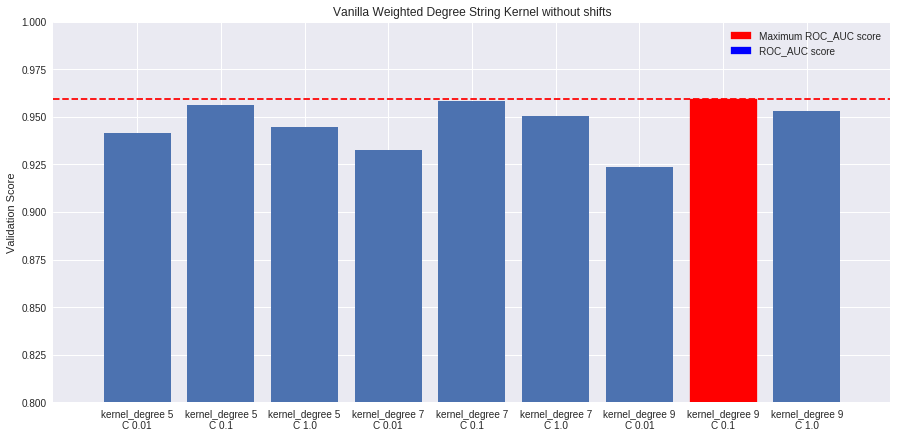

In [0]:
kernel_degree = np.repeat([5, 7, 9], 3)
C = np.tile([0.01, 0.1, 1], 3)
AUROC = [0.941265, 0.955983, 0.944876, 0.932377, 0.958132, 0.950292, 0.923636, 0.959484, 0.953307]

fig, ax = plt.subplots()

x_range = np.arange(len(kernel_degree))
barlist = plt.bar(x_range, AUROC)
plt.ylim([0.8, 1])
plt.xlim([-1, len(x_range)])
plt.xticks(x_range, ['kernel_degree ' + str(k) + '\nC ' + str(c) for k, c in zip(kernel_degree, C)])
max_AUROC = max(AUROC)
plt.plot(np.concatenate(([-1], x_range, [len(x_range)])), np.repeat(max_AUROC, len(x_range) + 2), 'r--')

barlist[np.argmax(AUROC)].set_color('r')
plt.ylabel('Validation Score')
plt.title('Vanilla Weighted Degree String Kernel without shifts')

red_patch = mpatches.Patch(color='red', label='Maximum ROC_AUC score')
blue_patch = mpatches.Patch(color='blue', label='ROC_AUC score')

plt.legend(handles=[red_patch, blue_patch])

plt.show()

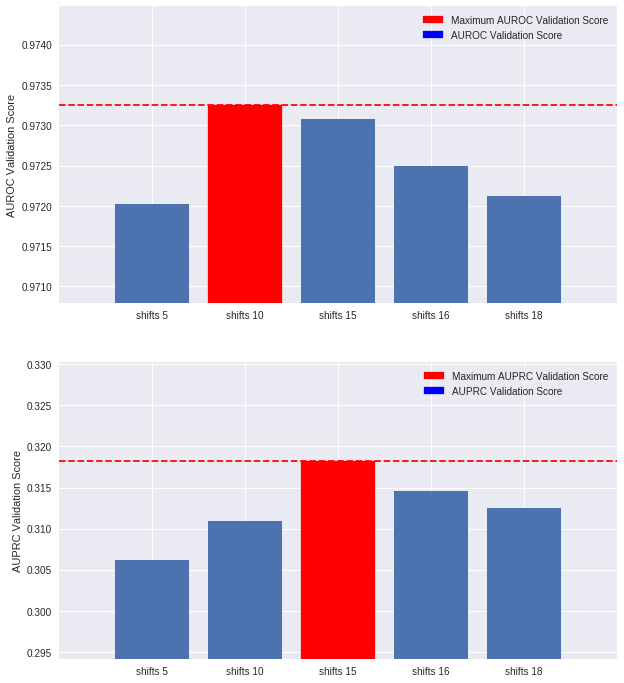

In [0]:
shifts = [5, 10, 15, 16, 18]

AUROC = [0.972021, 0.973248, 0.973073, 0.97250, 0.97212]
AUPRC = [0.306189, 0.310987, 0.318213, 0.31461, 0.31245]


rcParams['figure.figsize'] = 10, 12
fig = plt.figure()

def plot_score(score, shifts, ylabel):
  x_range = np.arange(len(shifts))
  barlist = plt.bar(x_range, score)
  
  score_range = max(score) - min(score)
  plt.ylim([min(score) - score_range, max(score) + score_range])
  plt.xlim([-1, len(x_range)])
  plt.ylabel(ylabel)
  max_score = max(score)
  plt.plot(np.concatenate(([-1], x_range, [len(x_range)])), np.repeat(max_score, len(x_range) + 2), 'r--')

  barlist[np.argmax(score)].set_color('r')

  red_patch = mpatches.Patch(color='red', label='Maximum ' + ylabel)
  blue_patch = mpatches.Patch(color='blue', label=ylabel)
  plt.legend(handles=[red_patch, blue_patch])


ax = plt.subplot(2, 1, 1)
plot_score(AUROC, shifts, 'AUROC Validation Score')

plt.subplot(2, 1, 2, sharex=ax)
plot_score(AUPRC, shifts, 'AUPRC Validation Score')
plt.xticks(np.arange(len(shifts)), ['shifts ' + str(sh) for sh in shifts])

plt.show()

As previously mentioned, due to long computational requirements, most parameters where optimized separately and not in a combined gridsearch fashion. We can expect that this iterative method will reach a local optimum in this parameter space, perhaps not the same obtained with a full brute force parameter search. Due to small differences from the other parameters, we concluded that such differences should not affect largely the last results. 

Results for shifts 14,, 15 and 16 depending on the train and test dataset were close. As these results were statistically close, we decided to continue with a shift parameter of 15, resulting to a lower computational cost. 

Here we provide some of the best classifiers that were tested. The results below are about the test set, as it was already provided separately. 

In [0]:
models = [['WeightedDegreeStringKernel', 0.9637 , 0.1554],
          ['WeightedDegreePositionStringKernel', 0.9731, 0.3182]]


classifiers = pd.DataFrame(models, columns=['model name', 'AUROC', 'AUPRC'])
classifiers

,model name,AUROC,AUPRC
0,WeightedDegreeStringKernel,0.9637,0.1554
1,WeightedDegreePositionStringKernel,0.9731,0.3182


## Final Model 

Here we load the best classifier and present the AUROC and AUPRC score obtained.

In [0]:
# The final version of this notebook was run in the colab cluster
# in order to simultaneously edit the final document

# from google.colab import files
# from sklearn.externals import joblib

# uploaded = files.upload() # upload the best model

# classifier = joblib.load('degree_9_shift_15_C_1.joblib.pkl')

In [0]:
feats_test  = sg.StringCharFeatures(list(X_test), sg.DNA)
predictions = classifier.apply(feats_test).get_values()

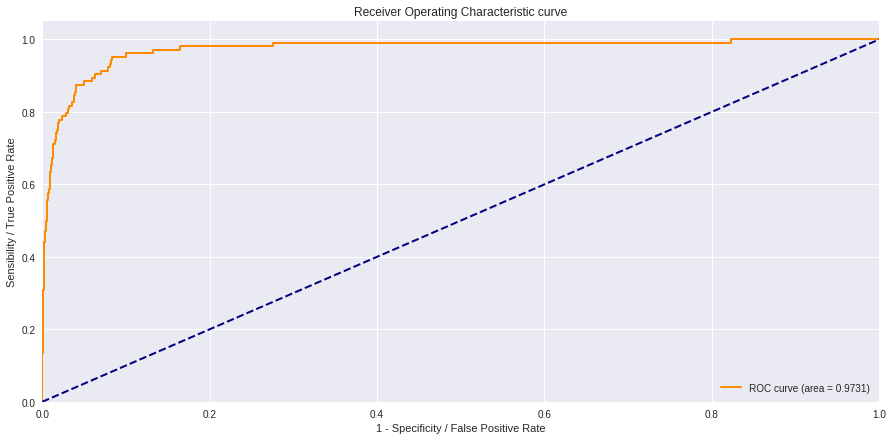

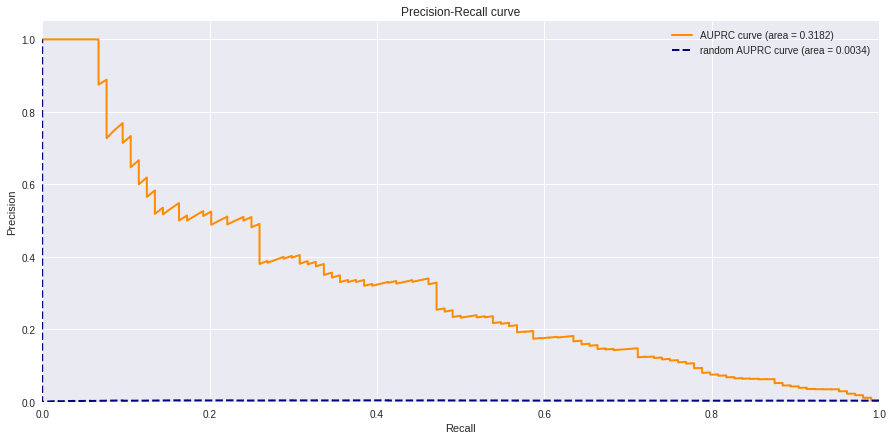

In [0]:
plot_roc_curve(y_test, predictions)

## Discussion

The results obtained on this dataset are similar to the ones obtained in the C. Elegans dataset, in the sense that the use of the string kernel with shifts greatly improves the predictive power of the model. However, the severity of class imbalance in this dataset in combination with the computational complexity of the weighted degree string kernel with shifts and the limited amount of computational resources made this task more dificult compared to the previous one. The training times when using the string kernel with shifts proved to be very long (up to 50 hours locally) which limited our ability to try different parameters and potentially different combinations of kernel functions. 